In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def simulate_det_sir_model(beta, gamma, N, I0, R0, num_days):
    S, I, R = np.zeros(num_days), np.zeros(num_days), np.zeros(num_days)
    S[0] = N - I0 - R0
    I[0] = I0
    R[0] = R0

    for t in range(1, num_days):
        new_infections = beta * S[t-1] * I[t-1] / N
        new_recoveries = gamma * I[t-1]
        
        S[t] = S[t-1] - new_infections
        I[t] = I[t-1] + new_infections - new_recoveries
        R[t] = R[t-1] + new_recoveries
    return S, I, R

def simulate_stoc_sir_model(beta, gamma, N, I0, R0, num_days):
    S, I, R = np.zeros(num_days), np.zeros(num_days), np.zeros(num_days)
    S[0] = N - I0 - R0
    I[0] = I0
    R[0] = R0

    for t in range(1, num_days):
        new_infections = np.random.binomial(S[t-1], beta * I[t-1] / N)
        new_recoveries = np.random.binomial(I[t-1], gamma)

        S[t] = S[t-1] - new_infections
        I[t] = I[t-1] + new_infections - new_recoveries
        R[t] = R[t-1] + new_recoveries
    return S, I, R




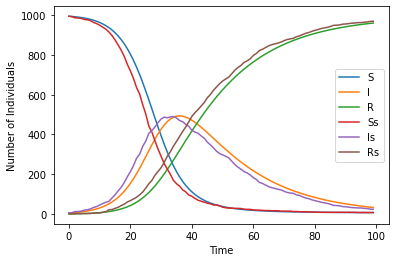

In [47]:
# Example usage:
beta = 0.25  # Infection rate
gamma = 1/20  # Recovery rate
population = 1000  # Total population size
initial_infected = 5  # Initial number of infected individuals
initial_recovered = 0  # Initial number of recovered individuals
num_days = 100  # Number of days to simulate

susceptible, infected, recovered = simulate_det_sir_model(beta, gamma, population, initial_infected, initial_recovered, num_days)
Ss,Is,Rs = simulate_stoc_sir_model(beta, gamma, population, initial_infected, initial_recovered, num_days)
# Plotting the results
time = np.arange(num_days)
plt.plot(time, susceptible, label='S')
plt.plot(time, infected, label='I')
plt.plot(time, recovered, label='R')

plt.plot(time, Ss, label='Ss')
plt.plot(time, Is, label='Is')
plt.plot(time, Rs, label='Rs')

plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()


In [27]:
# Run the simulation
t, S, I, R = simulate_sir_model(population, beta, gamma, num_days)

In [29]:
len(S)

1001

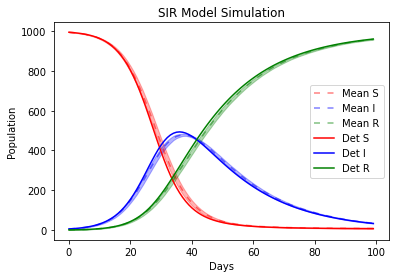

In [18]:
# Parameters
N = 1000  # Total population size
I0 = 5 # Initial number of infected individuals
R0 = 0  # Initial number of recovered individuals
beta = 0.25  # Infection rate
gamma = 1/20  # Recovery rate
num_days = 100

# makes 100 plots
num_simulations = 100

# Arrays to store simulation results
all_S = np.zeros((num_simulations, num_days))
all_I = np.zeros((num_simulations, num_days))
all_R = np.zeros((num_simulations, num_days))

# Run simulations
for i in range(num_simulations):
    # Simulate SIR model
    S, I, R = simulate_stoc_sir_model(beta, gamma, N, I0, R0, num_days)
    
    # Store results
    all_S[i] = S
    all_I[i] = I
    all_R[i] = R

# Calculate mean and confidence interval
mean_S = np.mean(all_S, axis=0)
mean_I = np.mean(all_I, axis=0)
mean_R = np.mean(all_R, axis=0)

std_S = np.std(all_S, axis=0)
std_I = np.std(all_I, axis=0)
std_R = np.std(all_R, axis=0)

lower_ci_S = mean_S - 1.96 * std_S / np.sqrt(num_simulations)
lower_ci_I = mean_I - 1.96 * std_I / np.sqrt(num_simulations)
lower_ci_R = mean_R - 1.96 * std_R / np.sqrt(num_simulations)

upper_ci_S = mean_S + 1.96 * std_S / np.sqrt(num_simulations)
upper_ci_I = mean_I + 1.96 * std_I / np.sqrt(num_simulations)
upper_ci_R = mean_R + 1.96 * std_R / np.sqrt(num_simulations)

# Plotting the mean and confidence interval
plt.plot(mean_S, label='Mean S', color='r', linestyle=(0,(4,5)), alpha=0.5)
plt.plot(mean_I, label='Mean I', color='b', linestyle=(0,(4,5)), alpha=0.5)
plt.plot(mean_R, label='Mean R', color='g', linestyle=(0,(4,5)), alpha=0.5)

plt.fill_between(range(num_days), lower_ci_S, upper_ci_S, color='r', alpha=0.3)
plt.fill_between(range(num_days), lower_ci_I, upper_ci_I, color='b', alpha=0.3)
plt.fill_between(range(num_days), lower_ci_R, upper_ci_R, color='g', alpha=0.3)

susceptible, infected, recovered = simulate_det_sir_model(beta, gamma, population, initial_infected, initial_recovered, num_days)

plt.plot(susceptible, label='Det S', color='r')
plt.plot(infected, label='Det I', color='b')
plt.plot(recovered, label='Det R', color='g')

plt.xlabel('Days')
plt.ylabel('Population')
plt.title('SIR Model Simulation')
plt.legend()
plt.show()

array([995.  , 993.68, 992.3 , 990.56, 988.44, 985.8 , 982.74, 979.14,
       974.68, 969.85, 963.57, 956.88, 948.43, 938.66, 927.59, 914.33,
       898.69, 880.66, 860.47, 837.09, 811.21, 782.85, 751.95, 717.28,
       681.51, 642.14, 602.33, 561.32, 518.56, 476.37, 434.45, 393.6 ,
       355.42, 319.45, 284.44, 252.75, 224.15, 197.94, 174.76, 154.45,
       136.1 , 120.12, 106.05,  93.89,  83.09,  73.87,  65.91,  59.14,
        53.19,  47.75,  42.99,  39.21,  35.77,  32.92,  30.27,  28.12,
        26.22,  24.41,  22.88,  21.44,  20.22,  18.96,  17.84,  16.97,
        16.16,  15.53,  14.72,  14.17,  13.55,  13.06,  12.61,  12.13,
        11.73,  11.34,  11.03,  10.74,  10.44,  10.17,   9.88,   9.69,
         9.38,   9.2 ,   9.06,   8.86,   8.67,   8.49,   8.33,   8.23,
         8.07,   7.93,   7.78,   7.71,   7.66,   7.61,   7.56,   7.48,
         7.44,   7.37,   7.33,   7.29])

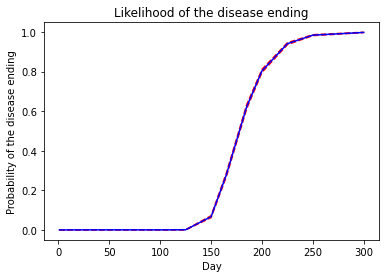

In [17]:
# Parameters
N = 1000  # Total population size
I0 = 5 # Initial number of infected individuals
R0 = 0  # Initial number of recovered individuals
beta = 0.25  # Infection rate
gamma = 1/20  # Recovery rate

# calculating likelihood: 
def calclikehood(sim): 
    disap = 0
    for i in range(sim): 
        S, I, R = simulate_stoc_sir_model(beta, gamma, N, I0, R0, num_days)
        if I[-1] == 0:
            disap += 1
    likelihood = disap / sim
    return likelihood 

def get_likehoodlist(sim):
    likelihoodlist = []
    for i in range(sim): 
        likelihoodlist.append(calclikehood(sim))
    return likelihoodlist

def compute_confidence_interval(data, alpha=0.95):
    sample_mean = np.mean(data)
    sample_var  = np.var(data)
    sample_std = np.std(data, ddof=1)
    sample_size = len(data)
    t_value = t.ppf((1 + alpha) / 2, df=sample_size-1)
    margin_of_error = t_value * sample_std / np.sqrt(sample_size)
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
    return confidence_interval, sample_mean, sample_var

m = []
day = [1,50,100,125,150,165,185,200,225,250,300]
lower_ci = []
upper_ci = []

for i in day:
    num_days = i
    confidence_interval, mean, sample_var  = compute_confidence_interval(get_likehoodlist(100))
    m.append(mean)
    lower_ci.append(confidence_interval[0])
    upper_ci.append(confidence_interval[1])

# confidence interval
plt.plot(day,lower_ci, color='r', linestyle='dashed')
plt.plot(day,upper_ci,  color='r', linestyle='dashed')
#mean
plt.plot(day,m, color='b')
plt.title('Likelihood of the disease ending')
plt.xlabel('Day')
plt.ylabel('Probability of the disease ending')
plt.show()